In [1]:
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)

import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

import scripts.points_and_polygons as points_and_polygons


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

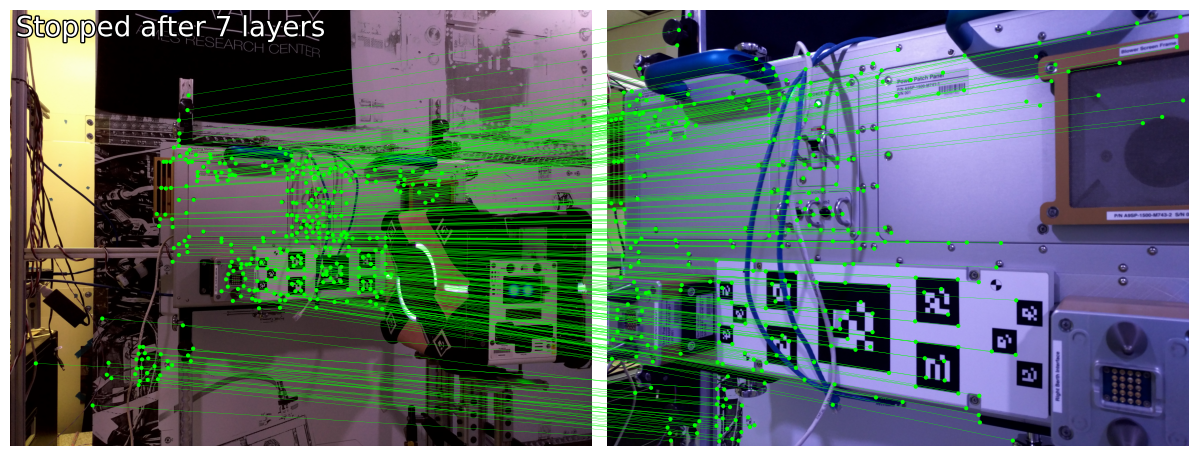

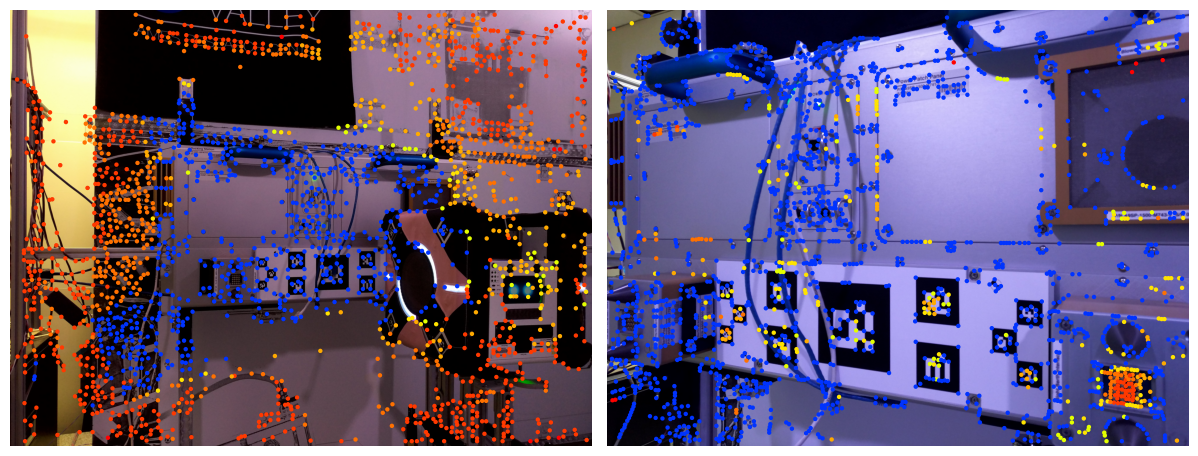

In [3]:
image0 = load_image('assets/DSC_0410.jpg')
image1 = load_image('assets/DSC_0411.jpg')

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0_no_batch_dim, feats1_no_batch_dim, matches01_no_batch_dim = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0_no_batch_dim["keypoints"], feats1_no_batch_dim["keypoints"], matches01_no_batch_dim["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stopped after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01_no_batch_dim["prune0"]), viz2d.cm_prune(matches01_no_batch_dim["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

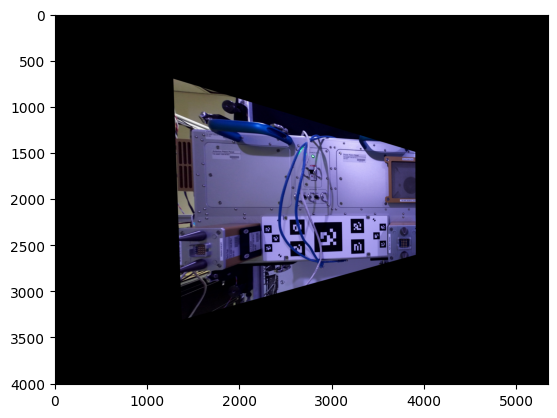

In [4]:
CV_image0 = cv.imread('assets/DSC_0410.jpg')
CV_image1 = cv.imread('assets/DSC_0411.jpg')

# Homography estimation

homography_result = cv.findHomography(m_kpts1.numpy(), m_kpts0.numpy(), cv.RANSAC, 5.0)

transformed_image = cv.warpPerspective(CV_image1, homography_result[0], (CV_image0.shape[1], CV_image0.shape[0]))

plt.imshow(cv.cvtColor(transformed_image, cv.COLOR_BGR2RGB))

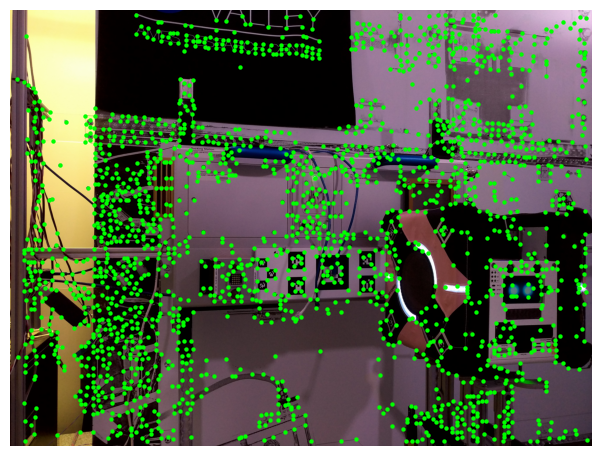

In [5]:
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load the SuperPoint feature extractor
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)

# Step 2: Load base image
image_path = 'assets/DSC_0410.jpg'
image = load_image(image_path).to(device)

# Step 3: Extract features from the image using SuperPoint extractor
feats = extractor.extract(image)
feats = rbd(feats)  # remove batch dimension


# Step 4: Plot the image and keypoints using viz2d
viz2d.plot_images([image])  # Display the image
viz2d.plot_keypoints([feats['keypoints']], colors='lime', ps=10)  # Plot keypoints

Corner A: (2000, 993)
Corner B: (3550, 1069)
Corner C: (1913, 3042)
Corner D: (3377, 3053)


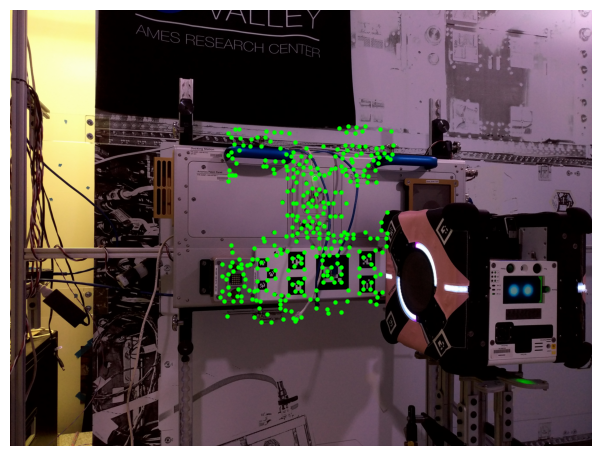

In [6]:
vertices = [(2000, 993), (3550, 1069), (3377, 3053), (1913, 3042)]
corners = points_and_polygon.identify_corners(vertices)
print("Corner A:", corners['A'])
print("Corner B:", corners['B'])
print("Corner C:", corners['C'])
print("Corner D:", corners['D'])


filtered_features = points_and_polygon.filter_keypoints(feats0_no_batch_dim, feats0, corners)


# Step 4: Plot the image and keypoints using viz2d
viz2d.plot_images([image])  # Display the image
viz2d.plot_keypoints(filtered_features['keypoints'], colors='lime', ps=10)  # Plot keypoints

In [ ]:
matches01 = matcher({"image0": filtered_features, "image1": feats1})
filtered_features_no_batch_dim, feats1_no_batch_dim, matches01 = [
    rbd(x) for x in [filtered_features, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = filtered_features_no_batch_dim["keypoints"], feats1_no_batch_dim["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stopped after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

In [ ]:
CV_image0 = cv.imread('assets/DSC_0410.jpg')
CV_image1 = cv.imread('assets/DSC_0411.jpg')

# Homography estimation

homography_result = cv.findHomography(m_kpts1.numpy(), m_kpts0.numpy(), cv.RANSAC, 5.0)

transformed_image = cv.warpPerspective(CV_image1, homography_result[0], (CV_image0.shape[1], CV_image0.shape[0]))

plt.imshow(cv.cvtColor(transformed_image, cv.COLOR_BGR2RGB))